In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import talib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Target encoding

In [ ]:
# Define the window size and threshold percentage
df = pd.read_csv('BTC-USD')
window_size = 10 # 5 days befor and 5 days after
threshold_percentage = 5  # 5% change

# Calculate the threshold_value as a percentage of the closing price
threshold_value = df['Close'] * threshold_percentage / 100

# Initialize a column for combined refined minima and maxima with percentage threshold
df['label'] = 0

# Loop through the dataframe and apply the combined condition with percentage threshold
for i in range(window_size, len(df) - window_size):
    current_window = df['Close'].iloc[i - window_size//2 : i + window_size//2 + 1]
    current_point = df['Close'].iloc[i]
    
    # Check if current point is minima or maxima in the window
    if current_point == min(current_window) and abs(current_point - max(current_window)) > threshold_value.iloc[i]:
        df.at[i, 'label'] = -1
    elif current_point == max(current_window) and abs(current_point - min(current_window)) > threshold_value.iloc[i]:
        df.at[i, 'label'] = 1

# Dropped noisy periods and created the encoded column called label

In [ ]:
main_df = pd.read_csv('Encoded_BTC.csv', index_col='Date', parse_dates=True)

# main_df = main_df.loc['2020-09-15':'2022-08-01'].drop(columns=['Unnamed: 0', 'Adj Close'])


# Plotting the data from main_df
plt.figure(figsize=(15, 7))
plt.plot(main_df.index, main_df['Close'], label='Closing Price', alpha=0.7)
if 'label' in main_df.columns:
    plt.scatter(main_df.index[main_df['label'] == -1], main_df['Close'][main_df['label'] == -1], color='green', label='Minima (-1)')
    plt.scatter(main_df.index[main_df['label'] == 1], main_df['Close'][main_df['label'] == 1], color='blue', label='Maxima (1)')
plt.title('Test Data: Closing Prices with Minima and Maxima')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
print(main_df['label'].value_counts())
main_df

In [130]:
def calculate_metrics(ticker, feature_lags=[3, 8, 14]):
    """
    Calculate a variety of metrics for a given stock ticker, including moving averages, rate of change (ROC),
    on-balance volume (OBV), and the relative strength index (RSI). Also calculates lagged versions of these metrics
    based on the `lags` input.

    Args:
        ticker (str): The stock ticker to calculate metrics for.
        period (int): The period to use for calculating metrics.
        threshold (float): The threshold to use for calculating metrics.
        lags (list of int): The lag periods to use for calculating lagged metrics.
        refresh (bool, optional): Whether to refresh the data. Defaults to False.

    Returns:
        pandas.DataFrame: A DataFrame with the calculated metrics and labels.
    """

    df = pd.read_csv("Encoded_BTC.csv", parse_dates=True, index_col='Date')

    main_df = df.loc['2020-09-15':'2022-08-01'].drop(columns=['Unnamed: 0', 'Adj Close'])

    main_df.columns = [f'BTC_{column}' for column in main_df.columns]


    metrics_df = pd.DataFrame()

    # Calculate base metrics
    rsi = ta.momentum.RSIIndicator(main_df[f"{ticker}_Close"], window=14).rsi()
    metrics_df[f"{ticker}_RSI"] = rsi.shift(periods=1)


    rolling_std_shifted = main_df[f"{ticker}_Close"].rolling(window=20).std().shift(periods=1)
    metrics_df[f"{ticker}_Bollinger_Up"] = (main_df[f"{ticker}_Close"].rolling(window=20).mean().shift(periods=1) + 2 * rolling_std_shifted)
    metrics_df[f"{ticker}_Bollinger_Down"] = (main_df[f"{ticker}_Close"].rolling(window=20).mean().shift(periods=1) - 2 * rolling_std_shifted)

    adx = talib.ADX(main_df[f"{ticker}_High"], main_df[f"{ticker}_Low"], main_df[f"{ticker}_Close"], timeperiod=14)
    metrics_df[f"{ticker}_ADX"] = adx.shift(periods=1)

    macd_line, signal_line, _ = talib.MACD(
        main_df[f"{ticker}_Close"], fastperiod=12, slowperiod=26, signalperiod=9
    )
    metrics_df[f"{ticker}_MACD"] = (macd_line - signal_line).shift(periods=1)

    obv = ta.volume.OnBalanceVolumeIndicator(
        main_df[f"{ticker}_Close"], main_df[f"{ticker}_Volume"]
    ).on_balance_volume()
    metrics_df[f"{ticker}_OBV"] = obv.shift(periods=1)

    # Calculate lagged metrics
    for lag in feature_lags:
        # Use shift to create lagged features, to avoid looking ahead in time
        metrics_df[f"{ticker}_Delta_ADX_{lag}"] = adx.diff(lag).shift(periods=1)
        
        metrics_df[f"{ticker}_MA_{lag}"] = (
            main_df[f"{ticker}_Close"].rolling(window=lag).mean().shift(periods=1)
        )
        metrics_df[f"{ticker}_ROC_{lag}"] = talib.ROC(
            main_df[f"{ticker}_Close"], timeperiod=lag
        ).shift(periods=1)
        metrics_df[f"{ticker}_OBV_ROC_{lag}"] = obv.pct_change(periods=lag).shift(
            periods=1
        )
        metrics_df[f"{ticker}_Delta_RSI_{lag}"] = rsi.diff(lag).shift(periods=1)

    # Handle missing values
    metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan)
    metrics_df.dropna(inplace=True)

    final_df = metrics_df.join(main_df[f"{ticker}_label"])

    # # Validate data types
    assert set(final_df.dtypes) <= {np.dtype("float64"), np.dtype("int64")}, "Unexpected data types in DataFrame"

    return final_df

In [ ]:
def X_and_Y_for_ML(ticker, feature_lags=[ 9 ,14, 21, 25, 30], days_back = 100):
    
    df = calculate_metrics(
        ticker, feature_lags=feature_lags)

    X = df.drop(columns=[f"{ticker}_label"])
    Y = df[f"{ticker}_label"].copy()

    # Use all data except last day for training, and last day for testing
    X_train, X_test, Y_train, Y_test = X[:-days_back], X[-days_back:], Y[:-days_back], Y[-days_back:]

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

    # X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values

    return X_train, X_test, Y_train, Y_test


# LSTM

In [133]:
# Imports
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

data = calculate_metrics('BTC')

# 1. Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop('BTC_label', axis=1))

labels = data['BTC_label'].values.reshape(-1, 1)  # use a different variable name for labels and reshape

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
encoded_labels = encoder.fit_transform(labels)

# 2. Prepare sequences
sequence_length = 10  # for example
X, y_seq = [], []
for i in range(len(data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y_seq.append(encoded_labels[i + sequence_length])  # use encoded_labels here

X = np.array(X)
y_seq = np.array(y_seq)

# 3. Calculate class weights
unique_labels = np.unique(data['BTC_label'])
class_weights = compute_class_weight('balanced', classes=unique_labels, y=data['BTC_label'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}  # adjust index for one-hot encoding

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_seq, test_size=0.2, shuffle=False)


# 5. Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(3, activation='softmax'))  # Ensure 3 units for 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])  # We'll stick with accuracy for now

# 6. Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# 7. Predict and evaluate
predictions_LSTM = model.predict(X_test)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100


2023-08-23 20:37:02.492907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:02.747431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:02.821691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:03.073469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:03.169164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.4366 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-08-23 20:37:04.167168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:04.257563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:04.310214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 3s 80ms/step - loss: 1.1034 - accuracy: 0.4366 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0989 - val_accuracy: 0.2171 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 1s 32ms/step - loss: 1.1055 - accuracy: 0.5283 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0872 - val_accuracy: 0.3256 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 1.1086 - accuracy: 0.0955 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2032 - val_accuracy: 0.0698 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
17/17 [==============================] - 0s 26ms/step - loss: 1.1034 - accuracy: 0.0565 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1184 - val_accuracy: 0.1473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
17/17 [==============================] -

2023-08-23 20:37:47.285765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:47.348409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 20:37:47.402256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 9ms/step


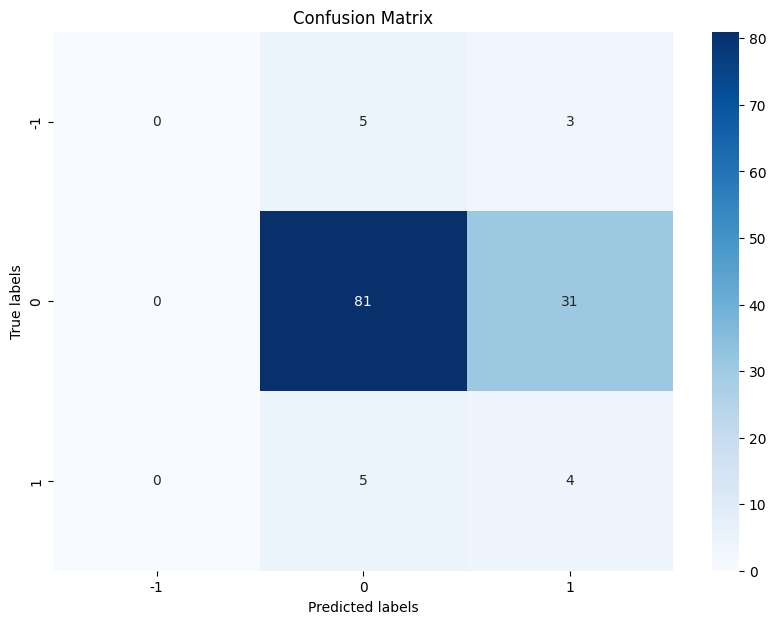

In [132]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert one-hot encoded predictions to label values
predicted_labels = np.argmax(predictions_LSTM, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
